See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go the other Colab

https://colab.research.google.com/github/google-research/vision_transformer/blob/linen/vit_jax_augreg.ipynb

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [ ]:
!pip install -qr vit_jax/requirements.txt

### Imports

In [2]:
from absl import logging
import flax
import jax

from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

# logging.set_verbosity(logging.INFO)

# # Shows the number of available devices.
# # In a CPU/GPU runtime this will be a single device.
# # In a TPU runtime this will be 8 cores.
# jax.local_devices()

In [3]:
# # Import files from repository.
# # Updating the files in the editor on the right will immediately update the
# # modules by re-importing them.

# import sys
# if './vision_transformer' not in sys.path:
#   sys.path.append('./vision_transformer')

# %load_ext autoreload
# %autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

/home/bach/anaconda3/envs/vit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'),
  acne04=('no_acne', 'level_1', 'level_2', 'level_3')
  
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [5]:
dataset = 'vit_acne04_ds'
batch_size = 32
get_config = common_config.get_config()
config = common_config.with_dataset(get_config, dataset)
num_classes = input_pipeline.get_directory_info(dataset)['num_classes']
config.batch = batch_size
config.pp.crop = 224

In [6]:
input_pipeline.get_directory_info(dataset)

{'num_examples': 1235,
 'num_classes': 4,
 'int2str': <function vit_jax.input_pipeline.get_directory_info.<locals>.<lambda>(id_)>,
 'examples_glob': 'vit_acne04_ds/*/*.jpg'}

In [7]:
# For details about setting up datasets, see input_pipeline.py on the right.
# ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_train = input_pipeline.get_data_from_directory(config=config, 
                                                  directory='/home/bach/Bach/Coding/Python/Hackathon2023/acne04/acne04_Classification/vit_ds_class',         
                                                  mode='train')
# ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
ds_test = input_pipeline.get_data_from_directory(config=config, 
                                                  directory='/home/bach/Bach/Coding/Python/Hackathon2023/acne04/acne04_Classification/vit_ds_class',         
                                                  mode='test')

del config  # Only needed to instantiate datasets.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

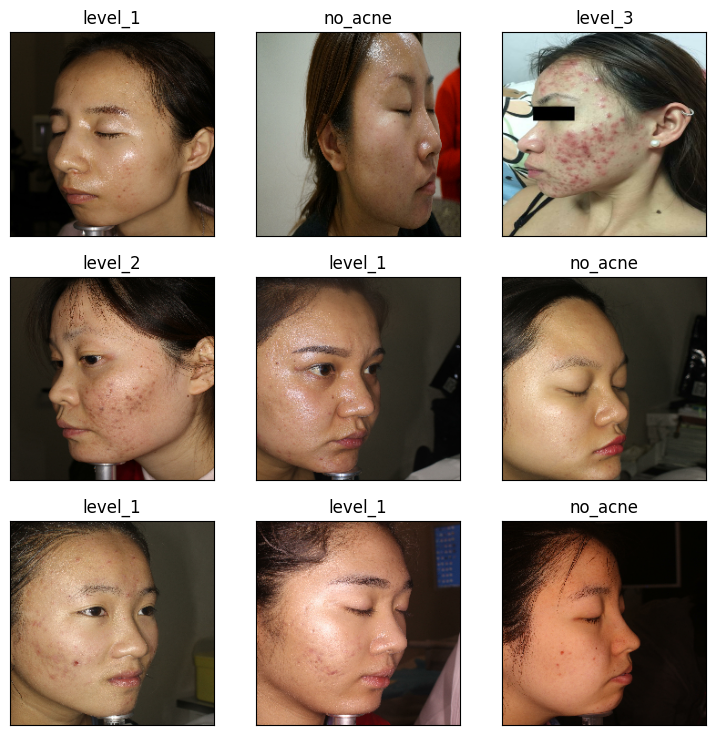

In [9]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter('acne04'), labels.argmax(axis=1))
show_img_grid(images, titles)

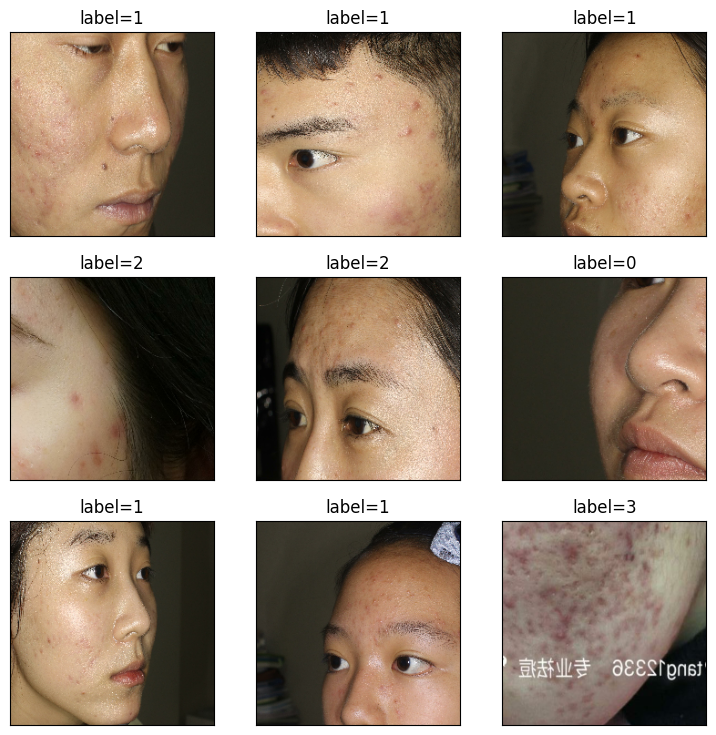

In [10]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [11]:
models_config.MODEL_CONFIGS

{'testing': classifier: token
 hidden_size: 10
 model_name: testing
 patches:
   size: !!python/tuple
   - 16
   - 16
 representation_size: null
 transformer:
   attention_dropout_rate: 0.0
   dropout_rate: 0.1
   mlp_dim: 10
   num_heads: 2
   num_layers: 1,
 'testing-unpooled': classifier: unpooled
 hidden_size: 10
 model_name: testing-unpooled
 patches:
   size: !!python/tuple
   - 16
   - 16
 representation_size: null
 transformer:
   attention_dropout_rate: 0.0
   dropout_rate: 0.1
   mlp_dim: 10
   num_heads: 2
   num_layers: 1,
 'ViT-Ti_16': classifier: token
 hidden_size: 192
 model_name: ViT-Ti_16
 patches:
   size: !!python/tuple
   - 16
   - 16
 representation_size: null
 transformer:
   attention_dropout_rate: 0.0
   dropout_rate: 0.0
   mlp_dim: 768
   num_heads: 3
   num_layers: 12,
 'ViT-S_16': classifier: token
 hidden_size: 384
 model_name: ViT-S_16
 patches:
   size: !!python/tuple
   - 16
   - 16
 representation_size: null
 transformer:
   attention_dropout_rate: 0.0

In [12]:
model_name = 'ViT-B_32'
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [13]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [14]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

### Evaluate

In [15]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (4,)
params_repl.cls: ArrayImpl (1, 4)


In [16]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [17]:
directory = '/home/bach/Bach/Coding/Python/Hackathon2023/vision_transformer/vit_acne04_ds'

In [18]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_directory_info(directory)['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [52]:
# Random performance without fine-tuning.
# get_accuracy(params_repl)

### Fine-tune

In [19]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 150
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [20]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)

#state
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)

opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)


In [21]:
type(opt_state_repl[0])

optax._src.base.EmptyState

In [22]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

In [23]:
from flax.training import train_state, checkpoints
 
update_fn_repl

100%|██████████| 10/10 [04:13<00:00, 25.39s/it]


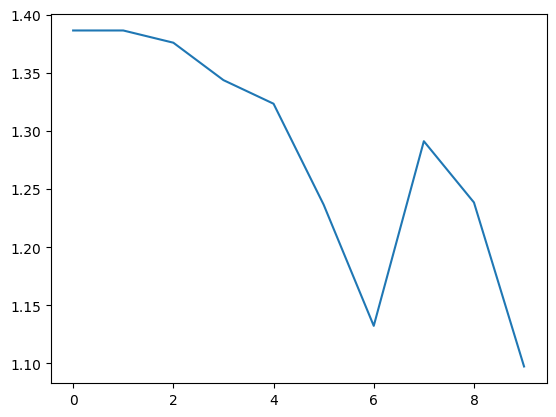

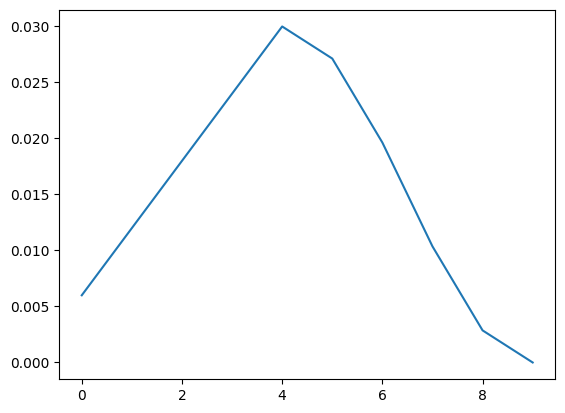

In [24]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [25]:
from flax.training import checkpoints

checkpoints.save_checkpoint(ckpt_dir="100epoch",  target=params_repl, step=total_steps, overwrite=True)

: 

: 

In [24]:
from flax.training import checkpoints
checkpoints.restore_checkpoint(ckpt_dir='100epoch', target=params_repl)

FrozenDict({
    Transformer: {
        encoder_norm: {
            bias: array([[-0.04149931, -0.05749115,  0.00819317, -0.02581718, -0.02648396,
                    -0.06948717, -0.01908513, -0.01218201, -0.02985534, -0.03595604,
                    -0.03451667,  0.00243049, -0.01677371, -0.01719027, -0.02416288,
                    -0.02732982, -0.02405796, -0.03957902, -0.06755038,  0.00266605,
                    -0.03663593, -0.03099952, -0.00865103, -0.02892362, -0.00512783,
                    -0.03485233, -0.04843673, -0.00974454, -0.1600885 , -0.04025263,
                     0.00471842, -0.0158392 ,  0.00919962, -0.0234812 ,  0.00483417,
                    -0.02304161, -0.01754938, -0.01255786, -0.04189333, -0.01235299,
                    -0.01621461, -0.03157182, -0.03392223, -0.01223516, -0.02863049,
                    -0.02987771, -0.00649865, -0.0313996 , -0.01069361, -0.03402265,
                    -0.01239587, -0.03350241,  0.07168328, -0.02881025, -0.03034859,
   

In [31]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

  0%|          | 0/38 [00:00<?, ?it/s]

: 

: 

### Inference

In [ ]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

In [ ]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

In [ ]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [ ]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')